**feature_extractor.py**

In [1]:
#!pip install tensorflow==2.11.0
#!pip install keras
!pip install mtcnn==0.1.0

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import cv2
from matplotlib import pyplot
from mtcnn import MTCNN
#keras.applications.resnet50.preprocess_input
#keras.applications.resnet50.ResNet50



In [3]:
import os

fol_path = "/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized"
folders = os.listdir(fol_path)

filenames = []

for folder in folders:
    for actor in os.listdir(os.path.join(fol_path,folder)):
        for file in os.listdir(os.path.join(fol_path,folder,actor)):
            filenames.append(os.path.join(fol_path,folder,actor,file))
            

In [4]:
pickle.dump(filenames,open('filenames.pkl','wb'))

In [5]:
#filenames = pickle.load(open('/kaggle/input/test-images/test_images/filenames.pkl','rb'))

In [6]:
#model = VGGFace(model='resnet50',include_top=False,input_shape=(224,224,3),pooling='avg')

In [7]:
#model2 = keras.applications.EfficientNetB7(
#    include_top=False,
#    input_shape=(224,224,3),
#    pooling='avg',
#)

In [8]:
#model = keras.applications.resnet_v2.ResNet50V2(
#    include_top=False,
#    input_tensor=None,
#    input_shape=(224,224,3),
#    pooling="avg",
#    classifier_activation="softmax",
#)

In [9]:
model = keras.applications.resnet50.ResNet50(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg'
)

2023-01-07 11:41:03.874370: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 1s 0us/step


In [10]:
#model.summary()

In [11]:
def feature_extractor(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img = np.expand_dims(img_array,axis=0)
    preprocessed_img = keras.applications.efficientnet.preprocess_input(expanded_img)
    result = model.predict(preprocessed_img).flatten()

    return result

In [12]:
features = []
for file in tqdm(filenames):
    features.append(feature_extractor(file,model))



100%|██████████| 8664/8664 [27:09<00:00,  5.32it/s]


In [13]:
pickle.dump(features,open('embeddings.pkl','wb'))

**test.py**

In [22]:
feature_list = np.array(pickle.load(open('/kaggle/working/embeddings.pkl','rb')))
#feature_list = np.array(pickle.load(open('/kaggle/input/test-images/test_images/embedding.pkl','rb')))
filenames = pickle.load(open('/kaggle/input/test-images/test_images/filenames.pkl','rb'))

In [15]:
#model = VGGFace(model='resnet50',include_top=False,input_shape=(224,224,3),pooling='avg')

In [23]:
model = keras.applications.resnet50.ResNet50(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg'
)

**Face Detection fro the sample image**

In [24]:
detector = MTCNN()

In [38]:
img_path = "/kaggle/input/test-images/test_images/varun.jpg"
sample_img = cv2.imread(img_path)
results = detector.detect_faces(sample_img)
x,y,width,height = results[0]['box']
print(x,y,width,height)
face = sample_img[y:y+height,x:x+width]

104 32 54 72


**Feature extraction of the face detected**

In [39]:
#  extract its features
image = Image.fromarray(face)
image = image.resize((224,224))

face_array = np.asarray(image)

face_array = face_array.astype('float32')

expanded_img = np.expand_dims(face_array,axis=0)
preprocessed_img = keras.applications.efficientnet.preprocess_input(expanded_img)
result = model.predict(preprocessed_img).flatten()
#print(result)
#print(result.shape)

**Find the cosine distance between face detected image and all the images in model**

In [40]:
# find the cosine distance of uploded image with all the image feature list
similarity = []
for i in range(len(feature_list)):
    similarity.append(cosine_similarity(result.reshape(1,-1),feature_list[i].reshape(1,-1))[0][0])
index_positions = sorted(list(enumerate(similarity)),reverse=True,key=lambda x:x[1])
positions = []
for pos in index_positions:
    positions.append(list(pos)[0])
    
predicted_imgs = []
for pos in positions[:5]:
    predicted_imgs.append(cv2.imread(filenames[pos]))

Uploded Image: 


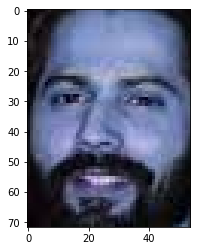

Predicted Top 5 Images: 
Name:  Varun_Dhawan


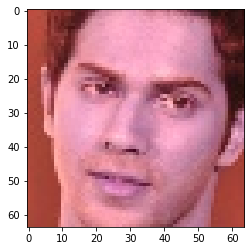

Name:  Paresh_Rawal


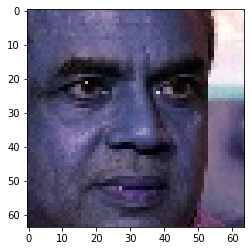

Name:  Aamir_Khan


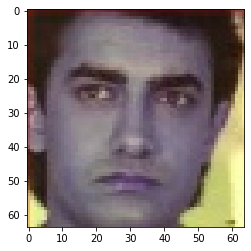

Name:  Arjun_Rampal


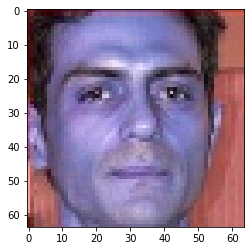

Name:  Arjun_Rampal


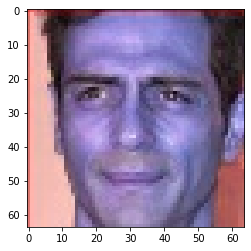

In [41]:
print("Uploded Image: ")
pyplot.imshow(face)
pyplot.show()

print("Predicted Top 5 Images: ")
n = 0
for img in predicted_imgs:
    
    print("Name: ", filenames[positions[n]].split('/')[6])
    pyplot.imshow(img)
    pyplot.show()
    n = n+1
